In [1]:
%run stdPackages.ipynb
slides = False # print to slides format if True
out_folder = os.path.join(d['curr'], 'Misc', 'Figs')
d['data'] = os.path.join(d['curr'],'Misc','Data')
read = {'variables': ['Fundamentals', 'LoadVariables', 'TransmissionLines', 'GeneratorsVariables','StorageVariables'],
        'maps': ['LoadMaps','GeneratorsMaps','StorageMaps'],
        'scalars': ['Scalars']}
db = dbFromWB(os.path.join(d['data'],'mBasicPH_storage.xlsx'), read)

# The effect of coupled markets on intermittency

In [2]:
H = 1000
rng = np.random.default_rng(seed=103)

## Create correlated samples

This helps us to create variation in demand and intermittent productivity based on correlations:

In [3]:
def createCorrMatrix(lH_lE, lH_WS, lH_SH, lE_WS, lE_SH, WS_SH):
    return np.array([[1, lH_lE, lH_WS, lH_SH],
                     [lH_lE, 1, lE_WS, lE_SH],
                     [lH_WS, lE_WS, 1, WS_SH],
                     [lH_SH, lE_SH, WS_SH, 1]])
def correlatedSample(covMatrix, capFactors = [0.5, 0.14]):
    means = np.array([5] * 4)
    dim_bounds = np.array([[0, 20],
                           [0, 50],
                           [0, 20],
                           [3, 7]])
    sample = sampling.BoundedMultivariateNormalDist(means, cov_matrix = createCorrMatrix(*covMatrix), dim_bounds = dim_bounds, size = H, rng = rng)
    return {'LoadVariation_E': loadVariation_E(sample),
            'LoadVariation_H': loadVariation_H(sample),
            'CapVariation': mapSample2CapVariation(sample, capFactors)}
def loadVariation_E(sample):
    return pd.DataFrame(sample[:,1]/sample[:,1].sum(axis=0),
                        index  = pd.Index(range(1,H+1), name = 'h'),
                        columns= pd.Index(['c1'], name = f'c_E')
                       ).stack()
def loadVariation_H(sample):
    return pd.DataFrame(sample[:,0]/sample[:,0].sum(axis=0),
                        index  = pd.Index(range(1,H+1), name = 'h'),
                        columns= pd.Index(['c1'], name = f'c_H')
                       ).stack()

def mapSample2CapVariation(sample, capFactors):
    return pd.DataFrame(sample[:,2:]/sample[:,2:].sum(axis=0) * H * np.array(capFactors), 
                        index = pd.Index(range(1,H+1), name = 'h'), 
                        columns = pd.Index(['g1_WS','g1_SH'], name = 'hvt')
                       ).assign(Standard = 1).stack()

Create correlated sample by providing list of correlations (see ```createCorrMatrix``` for the order of correlations) and add to the database:

In [4]:
db['Load_E'] = db['Load_E'] * H
db['Load_H'] = db['Load_H'] * H
db.symbols.update(correlatedSample([0.32,0.34,-0.27, 0.14,-0.09,-0.18]))
readSets(db, types = ['variable','set'])

Set up and solve:

In [5]:
m = mBasicPH_storage.mSimple(db)
m.solve()

Solution status 0: Optimization terminated successfully.


In [6]:
corr =pd.DataFrame({'Demand, H': m.db['LoadVariation_H'].xs('c1',level='c_H'),
                    'Demand, E': m.db['LoadVariation_E'].xs('c1',level='c_E'),
                    'Wind': m.db['CapVariation'].xs('g1_WS',level='hvt'),
                    'Solar heat': m.db['CapVariation'].xs('g1_SH',level='hvt')}).corr().round(2)
corr

,"Demand, H","Demand, E",Wind,Solar heat
"Demand, H",1.00,0.27,0.32,-0.19
"Demand, E",0.27,1.00,0.16,-0.03
Wind,0.32,0.16,1.00,-0.13
Solar heat,-0.19,-0.03,-0.13,1.00


In [7]:
print(corr.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Demand, H &  Demand, E &  Wind &  Solar heat \\
\midrule
Demand, H  &       1.00 &       0.27 &  0.32 &       -0.19 \\
Demand, E  &       0.27 &       1.00 &  0.16 &       -0.03 \\
Wind       &       0.32 &       0.16 &  1.00 &       -0.13 \\
Solar heat &      -0.19 &      -0.03 & -0.13 &        1.00 \\
\bottomrule
\end{tabular}



### Plot baseline solution:

To get an idea of the solution in the baseline scenario, we plot:
* The residual demand curve for heat and electricity,
* the sorted variation in marginal costs for $E$ and $H$, 

*1. The residual demand curve*

In [8]:
RDC = pd.DataFrame({'E': (m.hourlyLoad_E.xs('g1',level='g')-pdSum(mBasicPH_storage.subsetIdsTech_i(m.hourlyGeneratingCap_E, ['PV','WS'], m.db), 'id')).sort_values(ascending=False).reset_index(drop=True),
                    'H': (m.hourlyLoad_H.xs('g1',level='g')-pdSum(mBasicPH_storage.subsetIdsTech_i(m.hourlyGeneratingCap_H, 'SH',m.db), 'id')).sort_values(ascending=False).reset_index(drop=True)})
RDC.index = [i/(len(RDC)) for i in range(1, len(RDC)+1)]
RDC.at[0] = RDC.iloc[0]

*2. The sorted marginal costs:*

In [9]:
sortedPrices = pd.DataFrame({'$p_E$': m.db['marginalSystemCosts_E'].sort_values().reset_index(drop=True),
                             '$p_H$': m.db['marginalSystemCosts_H'].sort_values().reset_index(drop=True)})
sortedPrices.index = [i/(len(sortedPrices)) for i in range(1, len(sortedPrices)+1)]
sortedPrices.at[0] = sortedPrices.iloc[0]

In [10]:
%%capture
mult_graphs()
nplots = 2
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (14, (6*nrows)));
plt.subplots_adjust(hspace=0.35)

# plot 1: RDC
ax = plt.subplot(nrows, min(nplots,2), 1)
seaborn.lineplot(data=RDC, ax = ax, linewidth=3);
ax.set_xlabel(r'Capacity Factor', labelpad = 5);
ax.set_ylabel(r'$GJ$', labelpad = 5);
ax.set_xlim([0, 1]);
ax.hlines(0,0,1,colors='k',linewidth=1,alpha=0.5)
ax.set_title('Residual Demand Curve')

# Plot 2:
ax = plt.subplot(nrows, min(nplots,2),2)
seaborn.lineplot(data=sortedPrices, ax = ax, linewidth= 3);
ax.set_xlabel(r'Capacity Factor', labelpad = 5);
ax.set_ylabel(r'$€/GJ$', labelpad = 5);
ax.set_xlim([0, 1]);
ax.hlines(0,0,1,colors='k',linewidth=1,alpha=0.5)
ax.set_title('Sorted prices');

fig.tight_layout()
if slides:
    fig.savefig(f"{out_folder}\\mBasicPH_Storage_baseline_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicPH_Storage_baseline.pdf",edgecolor='k')

### Simulation 1: Increase BP generating capacity

In [11]:
db_before = m.db.copy()

In [12]:
loop = pd.Index(range(11), name = 'loop')
v0 = mBasicPH_storage.subsetIdsTech(m.db['GeneratingCap_E'], 'BP', m.db)
vT = mBasicPH_storage.subsetIdsTech(m.db['GeneratingCap_E'], 'BP', m.db)+25
grid = addGrid(v0,vT,loop,'GeneratingCap_E')
extract = ['marginalSystemCosts_E','marginalSystemCosts_H','meanConsumerPrice_E','meanConsumerPrice_H','marginalEconomicValue','FuelConsumption', 'Emissions']

In [13]:
solution_BP = m.loopSolveExtract(loop,[grid],extract)

Let's plot:
* The correlation between hourly electricity and heat prices for each loop.
* The change in average prices.
* The change in fuel consumption.
* The marginal economic value for intermittent technologies

In [14]:
correlation = pd.Series([pd.Series.corr(solution_BP['marginalSystemCosts_E'].xs('g1').xs(l,level='loop'), solution_BP['marginalSystemCosts_H'].xs('g1').xs(l,level='loop')) for l in loop])
meanPrices = pd.DataFrame({'$p_E$': solution_BP['meanConsumerPrice_E'].xs('g1'), '$p_H$': solution_BP['meanConsumerPrice_H'].xs('g1')})
fCon = (solution_BP['FuelConsumption'].xs('g1',level='g')/1000).unstack('BFt')
MEV = mBasicPH_storage.subsetIdsTech_i(solution_BP['marginalEconomicValue'], ['WS','SH'], m.db).unstack('id')
MEV.columns = MEV.columns.map({'g1_SH':'SH','g1_WS': 'WS'})

In [15]:
%%capture
nplots = 4
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows, min(nplots,2), figsize = (14, (4*nrows)));
plt.subplots_adjust(hspace=0.35) # create a bit of extra space between subplots

# plot 1: Mean prices:
ax = plt.subplot(nrows, min(nplots,2), 1) # access subplot 1
seaborn.lineplot(data = meanPrices, ax=ax, linewidth=3);
ax.set_ylabel('€/GJ');
ax.set_xlabel('loop');
ax.set_xlim([0,max(loop)]);
ax.set_title('Average prices');


# plot 2: Correlation:
ax = plt.subplot(nrows, min(nplots,2), 2) # access subplot 2
seaborn.lineplot(data = correlation, ax=ax, linewidth=3, legend=False);
ax.hlines(0,0,max(loop),colors='k',linewidth=1,alpha=0.5)
ax.set_xlabel('loop');
ax.set_xlim([0,max(loop)]);
ax.set_title('Correlation $p_E,p_H$');


# plot 3: 
ax = plt.subplot(nrows, min(nplots,2), 3) # access subplot 3
seaborn.lineplot(data = fCon, ax=ax, linewidth=3);
ax.set_ylabel('1000 GJ');
ax.set_xlim([0,max(loop)]);
ax.set_title('Fuel consumption');

# plot 4: MEV 
ax = plt.subplot(nrows, min(nplots,2), 4) # access subplot 4
seaborn.lineplot(data = MEV, ax=ax, linewidth=3);
ax.set_ylabel('€/(GJ/h)');
ax.set_xlim([0,max(loop)]);
ax.set_title('Marginal economic value');
fig.tight_layout()
if slides:
    fig.savefig(f"{out_folder}\\mBasicPH_storage_CHP_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicPH_storage_CHP.pdf",edgecolor='k')

### Simulation 2: Increase HP generating capacity

In [16]:
m.db = db_before.copy()

In [17]:
loop = pd.Index(range(11), name = 'loop')
v0 = mBasicPH_storage.subsetIdsTech(m.db['GeneratingCap_H'], 'HP', m.db)
vT = mBasicPH_storage.subsetIdsTech(m.db['GeneratingCap_H'], 'HP', m.db)+50
gridHP = addGrid(v0,vT,loop,'GeneratingCap_H')

In [18]:
solution_HP = m.loopSolveExtract(loop,[gridHP],extract)

In [19]:
correlation = pd.Series([pd.Series.corr(solution_HP['marginalSystemCosts_E'].xs('g1').xs(l,level='loop'), solution_HP['marginalSystemCosts_H'].xs('g1').xs(l,level='loop')) for l in loop])
meanPrices = pd.DataFrame({'$p_E$': solution_HP['meanConsumerPrice_E'].xs('g1'), '$p_H$': solution_HP['meanConsumerPrice_H'].xs('g1')})
fCon = (solution_HP['FuelConsumption'].xs('g1',level='g')/1000).unstack('BFt')
MEV = mBasicPH_storage.subsetIdsTech_i(solution_HP['marginalEconomicValue'], ['WS','SH'], m.db).unstack('id')
MEV.columns = MEV.columns.map({'g1_SH':'SH','g1_WS': 'WS'})

In [20]:
%%capture
nplots = 4
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows, min(nplots,2), figsize = (14, (4*nrows)));
plt.subplots_adjust(hspace=0.35) # create a bit of extra space between subplots

# plot 1: Mean prices:
ax = plt.subplot(nrows, min(nplots,2), 1) # access subplot 1
seaborn.lineplot(data = meanPrices, ax=ax, linewidth=3);
ax.set_ylabel('€/GJ');
ax.set_xlabel('loop');
ax.set_xlim([0,max(loop)]);
ax.set_title('Average prices');


# plot 2: Correlation:
ax = plt.subplot(nrows, min(nplots,2), 2) # access subplot 2
seaborn.lineplot(data = correlation, ax=ax, linewidth=3, legend=False);
ax.hlines(0,0,max(loop),colors='k',linewidth=1,alpha=0.5)
ax.set_xlabel('loop');
ax.set_xlim([0,max(loop)]);
ax.set_title('Correlation $p_E,p_H$');


# plot 3: 
ax = plt.subplot(nrows, min(nplots,2), 3) # access subplot 3
seaborn.lineplot(data = fCon, ax=ax, linewidth=3);
ax.set_ylabel('1000 GJ');
ax.set_xlim([0,max(loop)]);
ax.set_title('Fuel consumption');

# plot 4: MEV 
ax = plt.subplot(nrows, min(nplots,2), 4) # access subplot 4
seaborn.lineplot(data = MEV, ax=ax, linewidth=3);
ax.set_ylabel('€/(GJ/h)');
ax.set_xlim([0,max(loop)]);
ax.set_title('Marginal economic value');
fig.tight_layout()
if slides:
    fig.savefig(f"{out_folder}\\mBasicPH_storage_HP_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicPH_storage_HP.pdf",edgecolor='k')

### Simulation 3: Increase HP generating capacity with more heat storage

In [21]:
m.db = db_before.copy()

In [22]:
for v in ('GeneratingCap_H','chargeCap_H','sCap'):
    m.db[v] = (mBasicPH_storage.subsetIdsTech(m.db[v], 'HS', m.db)*50).combine_first(m.db[v])

In [23]:
solution_HP_HS = m.loopSolveExtract(loop,[gridHP],extract)

In [24]:
correlation_HS = pd.Series([pd.Series.corr(solution_HP_HS['marginalSystemCosts_E'].xs('g1').xs(l,level='loop'), solution_HP_HS['marginalSystemCosts_H'].xs('g1').xs(l,level='loop')) for l in loop])
meanPrices_HS = pd.DataFrame({'$p_E$': solution_HP_HS['meanConsumerPrice_E'].xs('g1'), '$p_H$': solution_HP_HS['meanConsumerPrice_H'].xs('g1')})
fCon_HS = (solution_HP_HS['FuelConsumption'].xs('g1',level='g')/1000).unstack('BFt')
MEV_HS = mBasicPH_storage.subsetIdsTech_i(solution_HP_HS['marginalEconomicValue'], ['WS','SH'], m.db).unstack('id')
MEV_HS.columns = MEV_HS.columns.map({'g1_SH':'SH','g1_WS': 'WS'})

<AxesSubplot:xlabel='loop'>

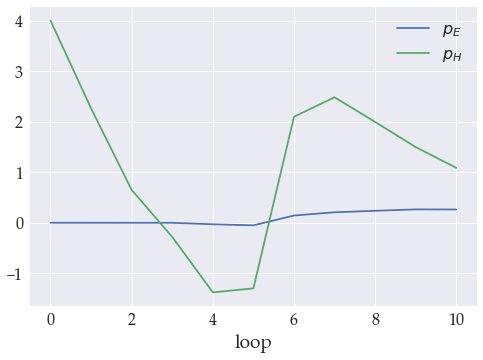

In [25]:
(meanPrices-meanPrices_HS).plot()

<AxesSubplot:xlabel='loop'>

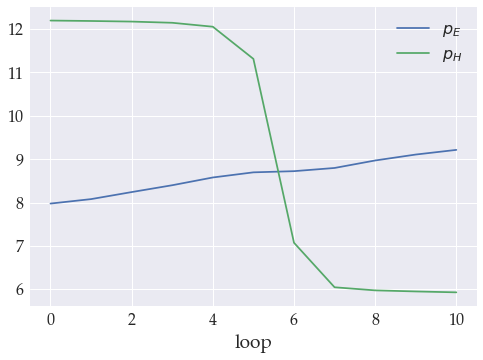

In [26]:
meanPrices_HS.plot()